In [2]:
import numpy as np

def pairwise_l2(X, C):
    """
    Tính ma trận khoảng cách Euclidean giữa mỗi điểm dữ liệu và mỗi centroid.
    X: (n_samples, n_features)
    C: (k, n_features)
    Trả về: D có shape (n_samples, k) với D[i, j] = ||X[i] - C[j]||_2
    """
    # Broadcasting: (n,1,d) - (1,k,d) -> (n,k,d) rồi norm theo trục đặc trưng
    return np.linalg.norm(X[:, None, :] - C[None, :, :], axis=2)

def wcss(X, labels, C):
    """
    Within-Cluster Sum of Squares (WCSS): tổng bình phương khoảng cách
    của điểm đến centroid của cụm mà điểm thuộc về.
    """
    total = 0.0
    for j in range(C.shape[0]):
        Xj = X[labels == j]
        if len(Xj) > 0:
            total += np.sum((Xj - C[j])**2)
    return float(total)

def init_kmeans_plus_plus(X, k, rng):
    """
    Khởi tạo k-means++: chọn ngẫu nhiên 1 tâm đầu,
    sau đó chọn các tâm còn lại theo phân phối tỉ lệ với khoảng cách bình phương lớn nhất.
    """
    n = X.shape[0]
    idx0 = rng.integers(0, n)
    centers = [X[idx0]]
    for _ in range(1, k):
        D = pairwise_l2(X, np.vstack(centers))  # (n, m)
        # Khoảng cách bình phương tới centroid gần nhất
        d2 = np.min(D**2, axis=1)
        probs = d2 / d2.sum()
        next_idx = rng.choice(n, p=probs)
        centers.append(X[next_idx])
    return np.vstack(centers)

def kmeans(X, k, max_iter=100, tol=1e-4, init="k-means++", random_state=42):
    """
    K-Means chuẩn với:
      - init in {"random", "k-means++"}
      - điều kiện dừng: ||C_new - C_old||_F <= tol * ||C_old||_F
      - xử lý cụm rỗng bằng cách re-seed centroid từ điểm xa nhất
    Trả về:
      labels: (n,), centers: (k,d), history: dict chứa WCSS theo vòng lặp
    """
    rng = np.random.default_rng(random_state)
    n, d = X.shape

    # Khởi tạo centroids
    if init == "k-means++":
        C = init_kmeans_plus_plus(X, k, rng)
    elif init == "random":
        C = X[rng.choice(n, size=k, replace=False)]
    else:
        raise ValueError("init must be 'random' or 'k-means++'.")

    hist_wcss = []
    for it in range(max_iter):
        # Bước gán cụm
        D = pairwise_l2(X, C)              # (n, k)
        labels = np.argmin(D, axis=1)      # (n,)

        # Bước cập nhật centroid
        C_new = C.copy()
        for j in range(k):
            Xj = X[labels == j]
            if len(Xj) > 0:
                C_new[j] = Xj.mean(axis=0)
            else:
                # Cụm rỗng: chọn lại centroid là điểm xa nhất so với mọi centroid hiện tại
                far_idx = np.argmax(np.min(D**2, axis=1))
                C_new[j] = X[far_idx]

        # Theo dõi hội tụ bằng WCSS
        current_wcss = wcss(X, labels, C_new)
        hist_wcss.append(current_wcss)

        # Điều kiện dừng theo chuẩn Frobenius tương đối
        denom = max(np.linalg.norm(C), 1e-12)
        delta = np.linalg.norm(C_new - C) / denom
        C = C_new
        if delta <= tol:
            break

    return labels, C, {"wcss": np.array(hist_wcss), "iters": it + 1}

# ===== Ví dụ chạy nhanh =====
if __name__ == "__main__":
    # Dữ liệu 2 chiều (Age, Expenditure) từ ví dụ trong bài
    X = np.array([
        [18, 80],
        [20, 90],
        [22, 85],
        [30, 50],
        [34, 64],
        [40, 60],
        [60, 30],
        [66, 40],
        [70, 25]
    ], dtype=float)

    labels, centers, hist = kmeans(X, k=3, init="k-means++", random_state=7)
    print("Centers:\n", centers)
    print("Labels:", labels)
    print("WCSS history:", hist["wcss"])
    print("Iterations:", hist["iters"])

Centers:
 [[65.33333333 31.66666667]
 [20.         85.        ]
 [34.66666667 58.        ]]
Labels: [1 1 1 2 2 2 0 0 0]
WCSS history: [1232.93333333  803.08333333  380.          380.        ]
Iterations: 4


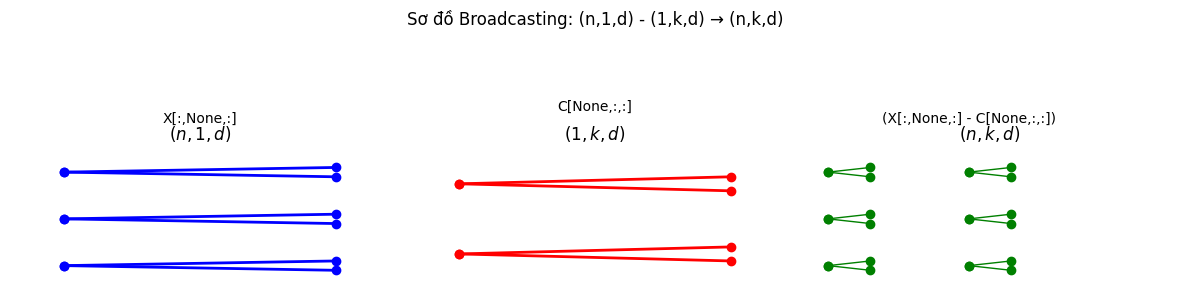

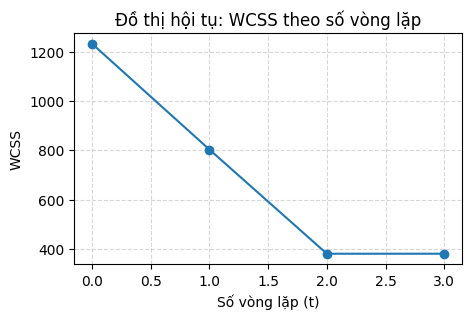

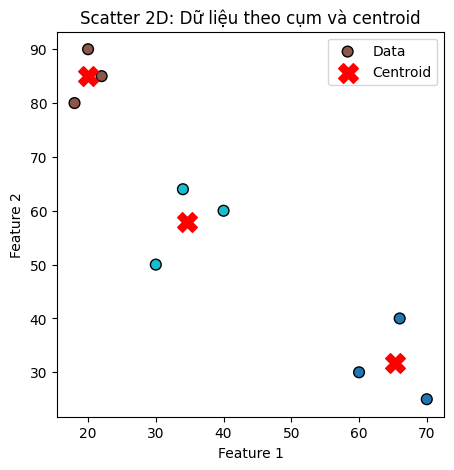

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# --- Sơ đồ Broadcasting ---
def plot_broadcasting_diagram(n=3, k=2, d=2):
    fig, axes = plt.subplots(1, 3, figsize=(12, 3))
    # (n,1,d)
    axes[0].set_title(r'$(n,1,d)$')
    for i in range(n):
        for j in range(d):
            axes[0].plot([0, 1], [i, i + 0.2*(j-0.5)], 'bo-', lw=2)
    axes[0].set_xlim(-0.2, 1.2)
    axes[0].set_ylim(-0.5, n-0.5)
    axes[0].axis('off')
    axes[0].text(0.5, n, "X[:,None,:]", ha='center', va='bottom', fontsize=10)

    # (1,k,d)
    axes[1].set_title(r'$(1,k,d)$')
    for i in range(k):
        for j in range(d):
            axes[1].plot([0, 1], [i, i + 0.2*(j-0.5)], 'ro-', lw=2)
    axes[1].set_xlim(-0.2, 1.2)
    axes[1].set_ylim(-0.5, k-0.5)
    axes[1].axis('off')
    axes[1].text(0.5, k, "C[None,:,:]", ha='center', va='bottom', fontsize=10)

    # (n,k,d)
    axes[2].set_title(r'$(n,k,d)$')
    for i in range(n):
        for j in range(k):
            for l in range(d):
                axes[2].plot([j, j+0.3], [i, i+0.2*(l-0.5)], 'go-', lw=1)
    axes[2].set_xlim(-0.2, k+0.5)
    axes[2].set_ylim(-0.5, n-0.5)
    axes[2].axis('off')
    axes[2].text(k/2, n, "(X[:,None,:] - C[None,:,:])", ha='center', va='bottom', fontsize=10)
    plt.suptitle("Sơ đồ Broadcasting: (n,1,d) - (1,k,d) → (n,k,d)")
    plt.tight_layout(rect=[0, 0, 1, 0.92])
    plt.show()

# --- Đồ thị hội tụ WCSS ---
def plot_wcss_history(hist_wcss):
    plt.figure(figsize=(5,3))
    plt.plot(hist_wcss, marker='o')
    plt.xlabel("Số vòng lặp (t)")
    plt.ylabel("WCSS")
    plt.title("Đồ thị hội tụ: WCSS theo số vòng lặp")
    plt.grid(True, ls='--', alpha=0.5)
    plt.show()

# --- Scatter 2D các cụm và centroid ---
def plot_clusters_2d(X, labels, centers):
    plt.figure(figsize=(5,5))
    scatter = plt.scatter(X[:,0], X[:,1], c=labels, cmap='tab10', s=60, edgecolor='k', label='Data')
    plt.scatter(centers[:,0], centers[:,1], c='red', marker='X', s=200, label='Centroid')
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.title("Scatter 2D: Dữ liệu theo cụm và centroid")
    plt.legend()
    plt.show()

# --- Ví dụ sử dụng ---
if __name__ == "__main__":
    # Sơ đồ broadcasting
    plot_broadcasting_diagram(n=3, k=2, d=2)

    # Đồ thị hội tụ WCSS
    plot_wcss_history(hist["wcss"])

    # Scatter 2D
    plot_clusters_2d(X, labels, centers)


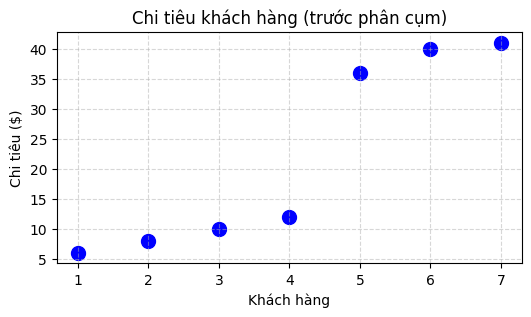

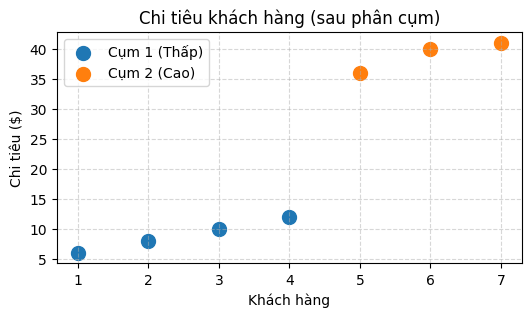

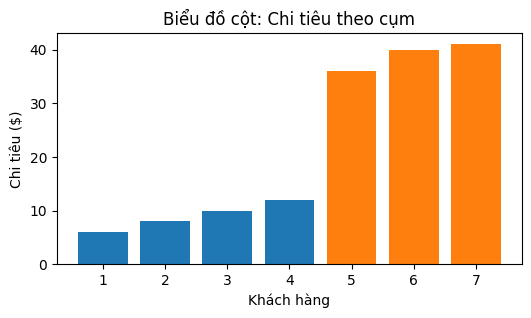

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Dữ liệu chi tiêu khách hàng (USD)
spending = np.array([6, 8, 10, 12, 36, 40, 41])

# --- Scatter plot chi tiêu trước phân cụm ---
plt.figure(figsize=(6,3))
plt.scatter(range(1, len(spending)+1), spending, color='blue', s=100)
plt.title("Chi tiêu khách hàng (trước phân cụm)")
plt.xlabel("Khách hàng")
plt.ylabel("Chi tiêu ($)")
plt.xticks(range(1, len(spending)+1))
plt.grid(True, ls='--', alpha=0.5)
plt.show()

# --- Phân cụm đơn giản: 2 cụm theo ngưỡng ---
threshold = 20
labels = (spending > threshold).astype(int)  # 0: thấp, 1: cao

# --- Scatter plot chi tiêu sau phân cụm ---
plt.figure(figsize=(6,3))
colors = ['tab:blue', 'tab:orange']
for cluster in [0, 1]:
    idx = np.where(labels == cluster)[0]
    plt.scatter(idx+1, spending[idx], color=colors[cluster], s=100, label=f'Cụm {cluster+1} ({ "Thấp" if cluster==0 else "Cao"})')
plt.title("Chi tiêu khách hàng (sau phân cụm)")
plt.xlabel("Khách hàng")
plt.ylabel("Chi tiêu ($)")
plt.xticks(range(1, len(spending)+1))
plt.legend()
plt.grid(True, ls='--', alpha=0.5)
plt.show()

# --- Biểu đồ cột chi tiêu theo cụm ---
plt.figure(figsize=(6,3))
bar_colors = [colors[l] for l in labels]
plt.bar(range(1, len(spending)+1), spending, color=bar_colors)
plt.title("Biểu đồ cột: Chi tiêu theo cụm")
plt.xlabel("Khách hàng")
plt.ylabel("Chi tiêu ($)")
plt.xticks(range(1, len(spending)+1))
plt.show()
